In [2]:
import pymc as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl


In [3]:
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)

mpl.rcParams["font.family"] = "Arial"

npg_palette = ["#E64B35FF", "#4DBBD5FF", "#00A087FF", "#3C5488FF", "#F39B7FFF"]
npg_palette2 = ["#8491B4FF", "#91D1C2FF", "#DC0000FF", "#7E6148FF", "#B09C85FF"]
#sns.set_palette(npg_palette)

sns.set_style('white', {'axes.linewidth': 0.85})
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

In [ ]:
sns.set_palette("deep")

In [5]:
species_order = ['dmel', 'dsim', 'dana', 'dvir', 'sleb']

In [6]:
df = pd.read_csv("survival_day3.csv")
survival = df["survival"].values

In [8]:
load = pd.read_excel('bacterial_load_1day.xlsx')

In [9]:
load_species_median = load.groupby('Species')['Load'].median()
log_load = np.log10(load_species_median[species_order].values + 1)

In [ ]:
x = (survival - survival.mean()) / survival.std()
y = (log_load - log_load.mean()) / log_load.std()

In [11]:
with pm.Model() as model:
    # Priors for the means and standard deviations of the two variables
    mu = pm.Normal("mu", mu=0, sigma=1, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1, shape=2)
    rho = pm.Uniform("rho", lower=-1, upper=1)

    # Covariance matrix
    cov = pm.math.stack([
        [sigma[0]**2, rho * sigma[0] * sigma[1]],
        [rho * sigma[0] * sigma[1], sigma[1]**2]
    ])

    # Observed standardized data
    obs = pm.MvNormal("obs", mu=mu, cov=cov, observed=np.stack([x, y], axis=1))

    # Sampling
    trace = pm.sample(2000, tune=1000, return_inferencedata=True, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, rho]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 103 seconds.


<Axes: title={'center': 'x'}>

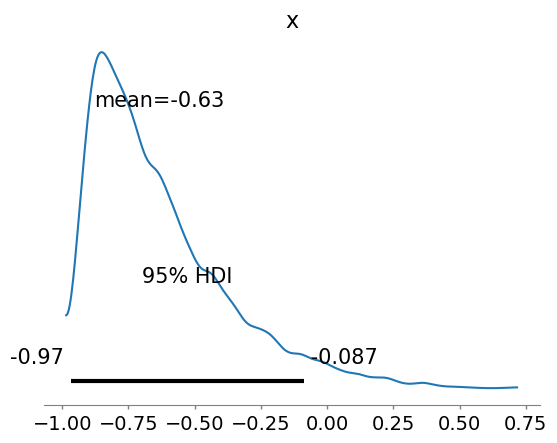

In [12]:
import arviz as az

# Extract posterior of rho
rho_posterior = trace.posterior['rho'].values.flatten()

# Plot posterior distribution of correlation
az.plot_posterior(rho_posterior, hdi_prob=0.95)


In [13]:
mean_corr = rho_posterior.mean()
hdi = az.hdi(rho_posterior, hdi_prob=0.95)

print(f"Posterior mean correlation: {mean_corr:.3f}")
print(f"95% credible interval: [{hdi[0]:.3f}, {hdi[1]:.3f}]")


Posterior mean correlation: -0.633
95% credible interval: [-0.969, -0.087]


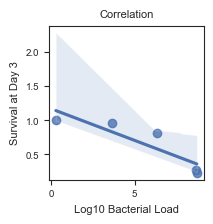

In [28]:
plt.figure(figsize=(2, 2))  
sns.regplot(x=log_load, y=survival)

plt.xlabel("Log10 Bacterial Load", fontsize=8)
plt.ylabel("Survival at Day 3", fontsize=8)
plt.title("Correlation", fontsize=8)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.savefig("species_load_survival_correlation.svg", bbox_inches='tight', dpi=300)

# starting phylogenetic correlation model

In [ ]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import aesara.tensor as at
from Bio import Phylo
import io

# load tree and compute phylogenetic correlation matrix
tree_file = "tree.txt"
tree = Phylo.read(tree_file, "newick")



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta0, beta1, sigma, lambda]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 33 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta0   1.194  0.426   0.373    1.974      0.015    0.010    1131.0     908.0   
beta1  -0.100  0.074  -0.221    0.043      0.003    0.002    1066.0     783.0   
lambda  0.493  0.218   0.091    0.866      0.005    0.004    1692.0    1615.0   
sigma   0.418  0.263   0.118    0.899      0.010    0.007     780.0    1042.0   

        r_hat  
beta0     1.0  
beta1     1.0  
lambda    1.0  
sigma     1.0  


array([[<Axes: title={'center': 'beta0'}>,
        <Axes: title={'center': 'beta0'}>],
       [<Axes: title={'center': 'beta1'}>,
        <Axes: title={'center': 'beta1'}>],
       [<Axes: title={'center': 'lambda'}>,
        <Axes: title={'center': 'lambda'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

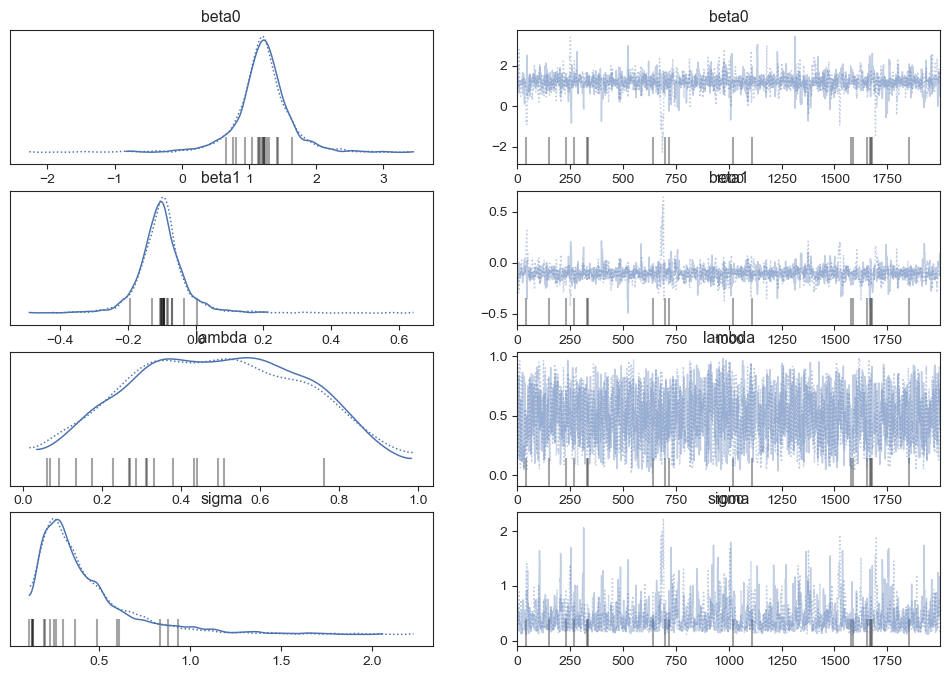

In [ ]:
import numpy as np
import pandas as pd
from Bio import Phylo
import pymc as pm
import arviz as az

tree_file = "tree.txt"
species_list = ["dmel", "dsim", "dana", "dvir", "sleb"]

load_species_median = load.groupby('Species')['Load'].median()
log_load = np.log10(load_species_median[species_order].values + 1)

load_arr = log_load
survival_arr = np.asarray(survival)

n = len(species_list)
if load_arr.ndim != 1 or survival_arr.ndim != 1:
    raise ValueError("load_arr and survival_arr must be 1-dimensional.")
if len(load_arr) != n or len(survival_arr) != n:
    raise ValueError(
        f"Length mismatch: species_list length={n}, "
        f"load length={len(load_arr)}, survival length={len(survival_arr)}"
    )

# read tree and check tip names
tree = Phylo.read(tree_file, "newick")
tips = {t.name: t for t in tree.get_terminals()}

missing = [s for s in species_list if s not in tips]
if missing:
    raise ValueError(f"The following species are not found in tree tip labels: {missing}")

# build Brownian-motion variance–covariance matrix (vcv)
def shared_path_length(tree, tip1_clade, tip2_clade):
    """Return the branch length from root to MRCA(tip1, tip2)."""
    mrca = tree.common_ancestor(tip1_clade, tip2_clade)
    return tree.distance(tree.root, mrca)

cov_phylo = np.zeros((n, n), dtype=float)
for i, sp1 in enumerate(species_list):
    for j, sp2 in enumerate(species_list):
        cov_phylo[i, j] = shared_path_length(tree, tips[sp1], tips[sp2])

# sanity: symmetric
cov_phylo = (cov_phylo + cov_phylo.T) / 2.0


# add tiny jitter to diagonal to help numerical stability
jitter = 1e-8
cov_phylo += np.eye(n) * jitter

# Bayesian PGLS with Pagel's λ (PyMC)
with pm.Model() as model:
    # priors
    beta0 = pm.Normal("beta0", mu=0.0, sigma=10.0)
    beta1 = pm.Normal("beta1", mu=0.0, sigma=10.0)
    sigma = pm.HalfNormal("sigma", sigma=1.0)           # residual scale
    lam = pm.Beta("lambda", alpha=2.0, beta=2.0)        # Pagel's lambda in [0,1]

    # construct lambda-adjusted covariance
    # phylo part scaled by lam, identity part scaled by (1-lam)
    phylo_cov_lambda = lam * cov_phylo + (1.0 - lam) * np.eye(n)

    # total covariance = phylo_cov_lambda * sigma^2
    cov_lambda = phylo_cov_lambda * sigma**2

    # for numerical stability / to ensure positive-definiteness, add small diag inside model
    cov_lambda = cov_lambda + np.eye(n) * 1e-10

    # mean vector from regression
    mu = beta0 + beta1 * load_arr

    # likelihood
    pm.MvNormal("obs", mu=mu, cov=cov_lambda, observed=survival_arr)

    # sampling settings
    trace = pm.sample(
        draws=2000,
        tune=1000,
        target_accept=0.9,
        return_inferencedata=True,
        random_seed=42,
        cores=1  # change to >1 if you want parallel chains and your machine supports it
    )

# summarize & plot
print(az.summary(trace, var_names=["beta0", "beta1", "lambda", "sigma"]))
az.plot_trace(trace, var_names=["beta0", "beta1", "lambda", "sigma"])


In [ ]:
import numpy as np

# extract posterior draws
beta0_post = trace.posterior["beta0"].values.flatten()
beta1_post = trace.posterior["beta1"].values.flatten()

# for each posterior sample, compute predicted survival
y_hat = beta0_post[:, None] + beta1_post[:, None] * load_arr[None, :]

# compute correlation per posterior draw
correlations = np.array([
    np.corrcoef(load_arr, y_hat_i)[0, 1]
    for y_hat_i in y_hat
])

# summarize correlation
mean_r = correlations.mean()
hdi_2p5, hdi_97p5 = np.percentile(correlations, [2.5, 97.5])

print(f"Mean phylogenetic correlation: {mean_r:.3f}")
print(f"95% credible interval: [{hdi_2p5:.3f}, {hdi_97p5:.3f}]")


Mean phylogenetic correlation: -0.875
95% credible interval: [-1.000, 1.000]


/var/folders/jt/wf6lflrs1_94wjjrq_r5mrvm0000gn/T/ipykernel_1665/2461145295.py:43: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


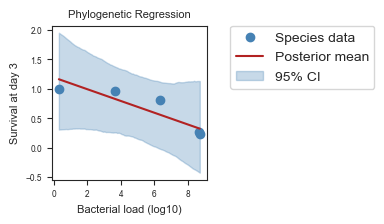

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# extract posterior draws
beta0_post = trace.posterior["beta0"].values.flatten()
beta1_post = trace.posterior["beta1"].values.flatten()

# range of predictor values
x_seq = np.linspace(load_arr.min(), load_arr.max(), 100)

# predict for each posterior draw
y_preds = np.array([b0 + b1 * x_seq for b0, b1 in zip(beta0_post, beta1_post)])

# create small figure
fig, ax = plt.subplots(figsize=(2, 2))

ax.scatter(log_load, survival_arr, color="steelblue", label="Species data")
ax.plot(x_seq, y_preds.mean(axis=0), color="firebrick", label="Posterior mean")

# 95% credible interval
ax.fill_between(
    x_seq,
    np.percentile(y_preds, 2.5, axis=0),
    np.percentile(y_preds, 97.5, axis=0),
    color="steelblue",
    alpha=0.3,
    label="95% CI"
)
plt.title("Phylogenetic Regression", fontsize=8)
ax.set_xlabel("Bacterial load (log10)", fontsize=8)
ax.set_ylabel("Survival at day 3", fontsize=8)
plt.legend(
    title="",
    bbox_to_anchor=(1.15, 1),  # position legend to the right of plot
    loc="upper left",
    borderaxespad=0.
)
ax.tick_params(axis="both", labelsize=6)

plt.tight_layout()
plt.savefig("correlation.svg", dpi=300)
